### Exploratory Data Analysis (EDA)

In this notebook, we conduct exploratory data analysis (EDA) on the final merged dataset produced during the data preparation stage. The dataset integrates in-situ water quality measurements, satellite-derived spectral features, climate variables, population density, and spatial indicators such as river mouth and junction proximity. At this stage, all variables—including Total Alkalinity (TA), Electrical Conductance (EC), and Dissolved Reactive Phosphorus (DRP)—are treated as independent variables for exploratory purposes, just like any other variable in the dataset. The goal of this EDA is to understand the structure of the data, examine variable distributions, explore relationships across variables, and identify any data quality issues or notable patterns present in the dataset.

In [11]:
# %pip install folium
# %pip install geopandas
# %pip install contextily

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from utils import primary_dataset
import folium

In [7]:
import seaborn as sns

#### Pulling the merged dataset

In [3]:
water_quality_df = pd.read_csv('data/wq.csv')
water_quality_df.head(10)

,Unnamed: 0,country,latitude,longitude,sample date,nir,green,swir16,swir22,ndmi,mndwi,pet,total alkalinity,electrical conductance,dissolved reactive phosphorus,month,pop_density_nn,distance_km_to_pd_cell,river_mouth
0,0,Namibia,-28.760833,17.730278,2011-01-02,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595,174.200000,128.912,555.0,10.0,2011-01-31,0.576990,0.325999,0
1,1,South Africa,-26.861111,28.884722,2011-01-03,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134,124.100000,74.720,162.9,163.0,2011-01-31,5.049022,0.251093,0
2,2,South Africa,-26.450000,28.085833,2011-01-03,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805,127.500000,89.254,573.0,80.0,2011-01-31,23.239988,0.418343,0
3,3,South Africa,-27.671111,27.236944,2011-01-03,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416,129.700000,82.000,203.6,101.0,2011-01-31,687.465759,0.069949,0
4,4,South Africa,-27.356667,27.286389,2011-01-03,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683,129.200000,56.100,145.1,151.0,2011-01-31,6.092811,0.231730,0
5,5,South Africa,-27.010111,26.698083,2011-01-04,12433.5,10433.5,9579.5,8531.5,0.129651,0.042672,98.600000,82.200,289.8,192.0,2011-01-31,77.849716,0.465583,0
6,6,South Africa,-25.127778,27.628889,2011-01-04,7814.0,5189.5,6664.0,5222.0,0.079431,-0.124394,105.500000,125.000,438.0,163.0,2011-01-31,3.473888,0.222919,0
7,7,South Africa,-25.206390,27.558000,2011-01-04,14137.5,10466.5,10315.5,8536.0,0.156300,0.007266,103.700005,116.620,568.0,69.0,2011-01-31,6.692756,0.383093,0
8,8,South Africa,-24.695140,27.409060,2011-01-04,15543.0,10647.0,11919.5,9642.5,0.131944,-0.056389,111.800000,181.831,583.0,158.0,2011-01-31,2.950710,0.252874,0
9,9,South Africa,-26.984722,26.632278,2011-01-04,13683.0,10207.0,14011.5,11850.5,-0.011862,-0.157091,98.200005,196.000,452.0,158.0,2011-01-31,7.390572,0.529222,0


#### Checking the missing values

In [4]:
water_quality_df.isna().sum()

Unnamed: 0                       0
country                          0
latitude                         0
longitude                        0
sample date                      0
nir                              0
green                            0
swir16                           0
swir22                           0
ndmi                             0
mndwi                            0
pet                              0
total alkalinity                 0
electrical conductance           0
dissolved reactive phosphorus    0
month                            0
pop_density_nn                   0
distance_km_to_pd_cell           0
river_mouth                      0
dtype: int64

#### 1) Population Density

In [5]:
# summary statistics
water_quality_df["pop_density_nn"].describe()

count    9319.000000
mean      101.669488
std       449.869426
min         0.000000
25%         2.179883
50%        10.131589
75%        54.044415
max      6180.402344
Name: pop_density_nn, dtype: float64

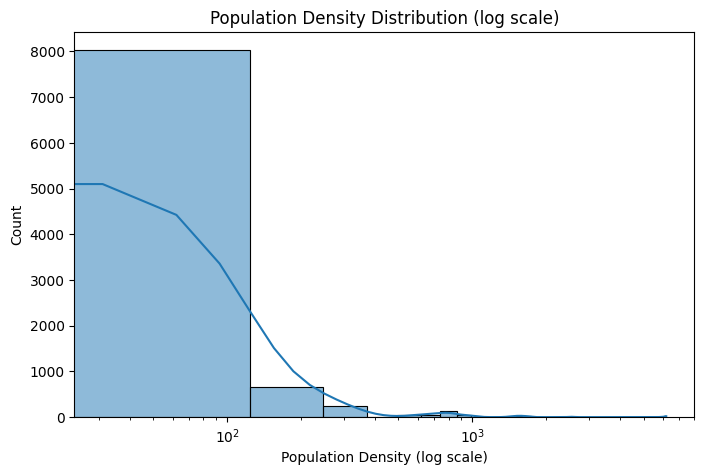

In [8]:
# Population Density Distribution (log scale)

plt.figure(figsize=(8, 5))
sns.histplot(
    water_quality_df["pop_density_nn"],
    bins=50,
    kde=True
)
plt.xscale("log")
plt.xlabel("Population Density (log scale)")
plt.ylabel("Count")
plt.title("Population Density Distribution (log scale)")
plt.show()

# Population density typically spans several orders of magnitude, ranging from sparsely populated rural areas to highly dense urban regions. 
# In the raw (linear) scale, a small number of very large values stretches the x-axis, making it difficult to see where the majority 
# of observations are concentrated. 
# Using a logarithmic scale helps address this issue by compressing the range of large values while preserving relative differences across the dataset. 
# This makes the overall distribution easier to interpret, allows patterns at lower density levels to become visible, 
# and provides a clearer view of the full spread of the data without being dominated by extreme outliers.

#### Observation

Population density around river sampling locations is highly right-skewed, with most sites in sparsely populated areas and a small number of urban locations contributing to a long tail of extreme values.

#### Spatial Distribution of Population Density

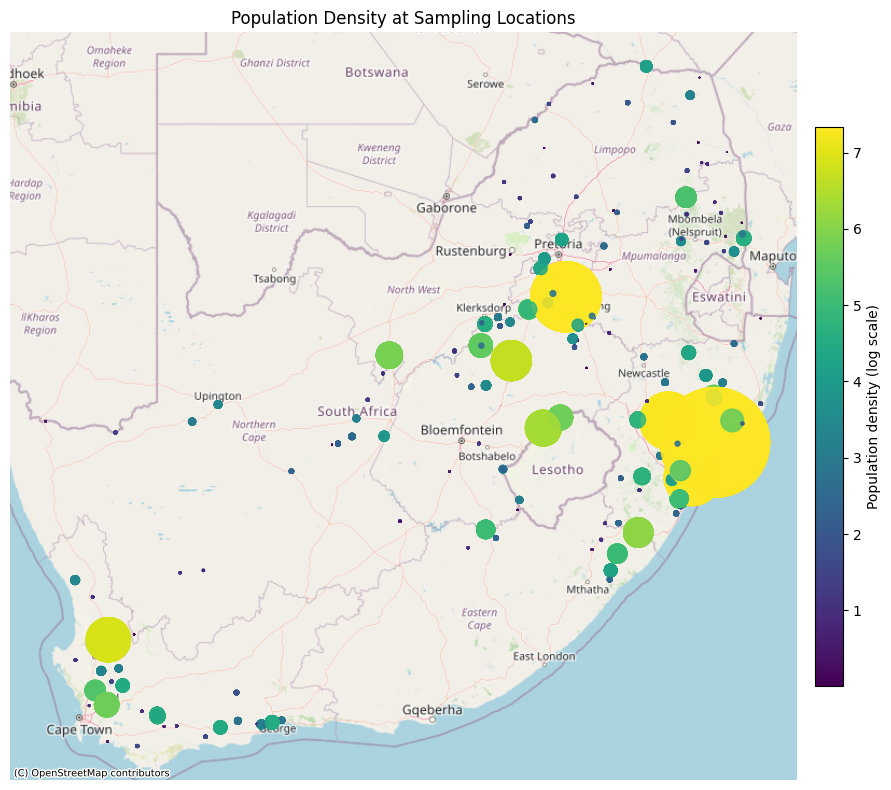

In [16]:
import contextily as ctx
from matplotlib.colors import Normalize

# Clean + keep only needed columns
df = water_quality_df.copy()
df.columns = df.columns.str.strip().str.lower()
df = df[["longitude", "latitude", "pop_density_nn", "pet"]].apply(pd.to_numeric, errors="coerce").dropna()

# GeoDataFrame -> Web Mercator (for basemap)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326").to_crs(3857)
gdf["log_pd"] = np.log1p(gdf["pop_density_nn"])

# Color scaling (clip extreme outliers for readability)
norm = Normalize(gdf["log_pd"].quantile(0.01), gdf["log_pd"].quantile(0.99))

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, column="log_pd", cmap="viridis", markersize=gdf["pop_density_nn"], alpha=0.85, legend=False, norm=norm) # markersize=25

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, attribution_size=7)

# Zoom to data extent
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin - (xmax - xmin)*0.05, xmax + (xmax - xmin)*0.05)
ax.set_ylim(ymin - (ymax - ymin)*0.05, ymax + (ymax - ymin)*0.05)

# Colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02, label="Population density (log scale)")

ax.set_title("Population Density at Sampling Locations")
ax.set_axis_off()
plt.tight_layout()
plt.show()

#### Observation

The spatial distribution of population density appears reasonable and geographically consistent. Higher population density values are concentrated around known urban and coastal regions (e.g., Gauteng, KwaZulu-Natal, and the Cape Town area), while lower densities dominate inland and rural areas. This pattern aligns well with known settlement and urbanization trends in southern Africa, suggesting that the spatial join and population density integration were performed correctly.

#### Spatial Matching Quality: Distance to Nearest Population Density Cell

In [17]:
water_quality_df["distance_km_to_pd_cell"].describe()

count    9319.000000
mean        0.342514
std         0.129586
min         0.025842
25%         0.251093
50%         0.358162
75%         0.452549
max         0.609135
Name: distance_km_to_pd_cell, dtype: float64

The distance between each water quality sampling location and its nearest population density grid cell is consistently small across the dataset. All 9,319 observations have valid matches, indicating that the spatial join was successful for every record.